  * See conversation with ChatGPT (Shape-biased Vision Transformer Attention)

In [1]:
import sys
sys.path.insert(0,'/home/ruthvik/ECE-697-Fall-2022')

In [2]:
import math
import torch
import numpy as np
import torchvision
import time
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from transformer.randomaug import RandAugment
import torchvision.transforms as transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from einops import rearrange, reduce, repeat
from transformer.Optim import ScheduledOptim
from transformer.randomaug import RandAugment
from einops.layers.torch import Rearrange, Reduce
from cosine_annealing_warmup import CosineAnnealingWarmupRestarts

In [3]:
print('PyTorch version:{}'.format(torch.__version__))
print('Is CUDA available:{}'.format(torch.cuda.is_available()))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device is{}'.format(device))

PyTorch version:1.12.1+cu113
Is CUDA available:True
Device iscuda:0


In [4]:
batch_size = 100
size = 32
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.Resize(size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


N = 2; M = 14;
transform_train.transforms.insert(0, RandAugment(N, M))
    
transform_test = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='/home/ruthvik/data/', train=True,
                                        download= True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle= True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='/home/ruthvik/data/', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
print('Number of examples in the training set:{}'.format(len(trainset)))

Number of examples in the training set:50000


In [6]:
print('Number of examples in the training set:{}'.format(len(testset)))

Number of examples in the training set:10000


In [7]:
n_batches = len(trainloader)
print('Number of batches in the training data loader:{}'.format(n_batches))

Number of batches in the training data loader:500


In [8]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int=3, patch_size: int=4, d_model: int=512, img_size: int=32,
                n_conv_layers: int=1):
        self.patch_size = patch_size
        super().__init__()
        # using a conv layer instead of a linear one -> performance gains
        # same_conv_layer means the shapes of input and output images is same as opposed to valid mode conv.
        self.same_conv_layer_stack = nn.ModuleList([nn.Conv2d(in_channels, in_channels, kernel_size=5, stride=1, padding=2) \
                                                    for i in range(n_conv_layers)])
        self.conv_proj_layer = nn.Conv2d(in_channels, d_model, kernel_size=patch_size, stride=patch_size)
        self.re_arrange_layer = Rearrange('b e (h) (w) -> b (h w) e')
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        #self.position_token = nn.Parameter(torch.randn((img_size // patch_size)**2 + 1, d_model))
        
                
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b, *_ = x.shape
        for same_conv_layer in self.same_conv_layer_stack:
            x = same_conv_layer(x)
        convd_img = self.conv_proj_layer(x)
        #print('Output of convolution:{}'.format(convd_img.shape))
        re_arranged_ip = self.re_arrange_layer(convd_img)
        #print('Rearranged ip:{}'.format(re_arranged_ip.shape))
        cls_token = repeat(self.cls_token, '() n e -> b n e', b=b)
        #print('CLS token:{}'.format(cls_token.shape))
        concated_ip = torch.cat([cls_token, re_arranged_ip], axis=1)
        #concated_ip += self.position_token
        #print('Concated ip:{}'.format(concated_ip.shape))
        
        return concated_ip

In [ ]:
src_img = torch.Tensor(np.random.randint(0, 255, size=(2,3, 32, 32)).astype(np.float32))
print('Original image:{}'.format(src_img.shape))
concated_ip = PatchEmbedding(n_conv_layers=2)(src_img).to(device=device)
print('projected and cls_toen concated image:{}:{}'.format(concated_ip.shape, concated_ip.dtype))

In [9]:
def get_patch_positions(img_size, patch_size, device='cuda'):
    """
    Return a tensor of shape (num_patches, 2) with (row, col) indices
    for each patch in the patch grid.
    """
    H = img_size // patch_size
    W = img_size // patch_size
    positions = []
    for r in range(H):
        for c in range(W):
            positions.append([r, c])
    # positions is a list of length H*W, each [r, c]
    patch_positions = torch.tensor(positions).to(device=device)  # shape (H*W, 2)
    return patch_positions


In [ ]:
# For 32x32images, patch_size=4 -> 8x8=64 patches
base_positions = get_patch_positions(32, 4)  # shape (64,2) or get_patch_positions_in_original_space
B = concated_ip.shape[0]
positions_2d_batched = base_positions.unsqueeze(0).repeat(B, 1, 1).to(device=device)  # (B, 64, 2)
print(positions_2d_batched.shape)

# Closely examining the neighbourhood correlated patch attention penalty method

In [ ]:
print("Image size:{}, Patch_size:{}, Patch_grid_size:{}".format((32,32), 8, (4,4)))
print("\n")
base_positions = get_patch_positions(32, 8)
print("patch_positions_grid:\n{}, \n and its shape:{}".format(base_positions, base_positions.shape))
rows = base_positions[:,0]
cols = base_positions[:,1]
print("\n")
print("rows:{}".format(rows))
print("cols:{}".format(cols))
print("\n")
# (2) Distances
row_diff = rows.unsqueeze(1) - rows.unsqueeze(0)  # still on GPU
print("rows_diff:\n{}".format(row_diff))
col_diff = cols.unsqueeze(1) - cols.unsqueeze(0)  # still on GPU
print("cols_diff:\n{}".format(col_diff))
dist_matrix = torch.sqrt(row_diff**2 + col_diff**2)
print("dist_matrix:\n{}".format(dist_matrix))
dist_weight = 1.0 / (1.0 + dist_matrix * 1.0)  # GPU
print("dist_weight:\n{}".format(torch.round(dist_weight, decimals=2).cpu().numpy()))

* Image size:(32, 32), Patch_size:8, Patch_grid_size:(4, 4)

* patch_positions_grid:
tensor([[0, 0],
        [0, 1],
        [0, 2],
        [0, 3],
        [1, 0],
        [1, 1],
        [1, 2],
        [1, 3],
        [2, 0],
        [2, 1],
        [2, 2],
        [2, 3],
        [3, 0],
        [3, 1],
        [3, 2],
        [3, 3]], device='cuda:0'), 
* and its shape:torch.Size([16, 2])

* rows:tensor([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3], device='cuda:0')
* cols:tensor([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3], device='cuda:0')
 
* rows_diff:

        [[ 0,  0,  0,  0, -1, -1, -1, -1, -2, -2, -2, -2, -3, -3, -3, -3],
        [ 0,  0,  0,  0, -1, -1, -1, -1, -2, -2, -2, -2, -3, -3, -3, -3],
        [ 0,  0,  0,  0, -1, -1, -1, -1, -2, -2, -2, -2, -3, -3, -3, -3],
        [ 0,  0,  0,  0, -1, -1, -1, -1, -2, -2, -2, -2, -3, -3, -3, -3],
        [ 1,  1,  1,  1,  0,  0,  0,  0, -1, -1, -1, -1, -2, -2, -2, -2],
        [ 1,  1,  1,  1,  0,  0,  0,  0, -1, -1, -1, -1, -2, -2, -2, -2],
        [ 1,  1,  1,  1,  0,  0,  0,  0, -1, -1, -1, -1, -2, -2, -2, -2],
        [ 1,  1,  1,  1,  0,  0,  0,  0, -1, -1, -1, -1, -2, -2, -2, -2],
        [ 2,  2,  2,  2,  1,  1,  1,  1,  0,  0,  0,  0, -1, -1, -1, -1],
        [ 2,  2,  2,  2,  1,  1,  1,  1,  0,  0,  0,  0, -1, -1, -1, -1],
        [ 2,  2,  2,  2,  1,  1,  1,  1,  0,  0,  0,  0, -1, -1, -1, -1],
        [ 2,  2,  2,  2,  1,  1,  1,  1,  0,  0,  0,  0, -1, -1, -1, -1],
        [ 3,  3,  3,  3,  2,  2,  2,  2,  1,  1,  1,  1,  0,  0,  0,  0],
        [ 3,  3,  3,  3,  2,  2,  2,  2,  1,  1,  1,  1,  0,  0,  0,  0],
        [ 3,  3,  3,  3,  2,  2,  2,  2,  1,  1,  1,  1,  0,  0,  0,  0],
        [ 3,  3,  3,  3,  2,  2,  2,  2,  1,  1,  1,  1,  0,  0,  0,  0]],
       
* cols_diff:

        [[ 0, -1, -2, -3,  0, -1, -2, -3,  0, -1, -2, -3,  0, -1, -2, -3],
        [ 1,  0, -1, -2,  1,  0, -1, -2,  1,  0, -1, -2,  1,  0, -1, -2],
        [ 2,  1,  0, -1,  2,  1,  0, -1,  2,  1,  0, -1,  2,  1,  0, -1],
        [ 3,  2,  1,  0,  3,  2,  1,  0,  3,  2,  1,  0,  3,  2,  1,  0],
        [ 0, -1, -2, -3,  0, -1, -2, -3,  0, -1, -2, -3,  0, -1, -2, -3],
        [ 1,  0, -1, -2,  1,  0, -1, -2,  1,  0, -1, -2,  1,  0, -1, -2],
        [ 2,  1,  0, -1,  2,  1,  0, -1,  2,  1,  0, -1,  2,  1,  0, -1],
        [ 3,  2,  1,  0,  3,  2,  1,  0,  3,  2,  1,  0,  3,  2,  1,  0],
        [ 0, -1, -2, -3,  0, -1, -2, -3,  0, -1, -2, -3,  0, -1, -2, -3],
        [ 1,  0, -1, -2,  1,  0, -1, -2,  1,  0, -1, -2,  1,  0, -1, -2],
        [ 2,  1,  0, -1,  2,  1,  0, -1,  2,  1,  0, -1,  2,  1,  0, -1],
        [ 3,  2,  1,  0,  3,  2,  1,  0,  3,  2,  1,  0,  3,  2,  1,  0],
        [ 0, -1, -2, -3,  0, -1, -2, -3,  0, -1, -2, -3,  0, -1, -2, -3],
        [ 1,  0, -1, -2,  1,  0, -1, -2,  1,  0, -1, -2,  1,  0, -1, -2],
        [ 2,  1,  0, -1,  2,  1,  0, -1,  2,  1,  0, -1,  2,  1,  0, -1],
        [ 3,  2,  1,  0,  3,  2,  1,  0,  3,  2,  1,  0,  3,  2,  1,  0]]
  
* dist_matrix:
*     [[0.0000, 1.0000, 2.0000, 3.0000, 1.0000, 1.4142, 2.2361, 3.1623, 2.0000, 2.2361, 2.8284, 3.6056, 3.00, 3.16, 3.60, 4.2426],
      [1.0000, 0.0000, 1.0000, 2.0000, 1.4142, 1.0000, 1.4142, 2.2361, 2.2361, 2.0000, 2.2361, 2.8284, 3.16, 3.00, 3.16, 3.6056],
      [2.0000, 1.0000, 0.0000, 1.0000, 2.2361, 1.4142, 1.0000, 1.4142, 2.8284, 2.2361, 2.0000, 2.2361, 3.60, 3.16, 3.00, 3.1623],
      [3.0000, 2.0000, 1.0000, 0.0000, 3.1623, 2.2361, 1.4142, 1.0000, 3.6056, 2.8284, 2.2361, 2.0000, 4.24, 3.60, 3.16, 3.0000],
      [1.0000, 1.4142, 2.2361, 3.1623, 0.0000, 1.0000, 2.0000, 3.0000, 1.0000, 1.4142, 2.2361, 3.1623, 2.00, 2.23, 2.82, 3.6056],
      [1.4142, 1.0000, 1.4142, 2.2361, 1.0000, 0.0000, 1.0000, 2.0000, 1.4142, 1.0000, 1.4142, 2.2361, 2.23, 2.00, 2.23, 2.8284],
      [2.2361, 1.4142, 1.0000, 1.4142, 2.0000, 1.0000, 0.0000, 1.0000, 2.2361, 1.4142, 1.0000, 1.4142, 2.82, 2.23, 2.00, 2.2361],
      [3.1623, 2.2361, 1.4142, 1.0000, 3.0000, 2.0000, 1.0000, 0.0000, 3.1623, 2.2361, 1.4142, 1.0000, 3.60, 2.82, 2.23, 2.0000],
      [2.0000, 2.2361, 2.8284, 3.6056, 1.0000, 1.4142, 2.2361, 3.1623, 0.0000, 1.0000, 2.0000, 3.0000, 1.00, 1.41, 2.23, 3.1623],
      [2.2361, 2.0000, 2.2361, 2.8284, 1.4142, 1.0000, 1.4142, 2.2361, 1.0000, 0.0000, 1.0000, 2.0000, 1.41, 1.00, 1.41, 2.2361],
      [2.8284, 2.2361, 2.0000, 2.2361, 2.2361, 1.4142, 1.0000, 1.4142, 2.0000, 1.0000, 0.0000, 1.0000, 2.23, 1.41, 1.00, 1.4142],
      [3.6056, 2.8284, 2.2361, 2.0000, 3.1623, 2.2361, 1.4142, 1.0000, 3.0000, 2.0000, 1.0000, 0.0000, 3.16, 2.23, 1.41, 1.0000],
      [3.0000, 3.1623, 3.6056, 4.2426, 2.0000, 2.2361, 2.8284, 3.6056, 1.0000, 1.4142, 2.2361, 3.1623, 0.00, 1.00, 2.00, 3.0000],
      [3.1623, 3.0000, 3.1623, 3.6056, 2.2361, 2.0000, 2.2361, 2.8284, 1.4142, 1.0000, 1.4142, 2.2361, 1.00, 0.00, 1.00, 2.0000],
      [3.6056, 3.1623, 3.0000, 3.1623, 2.8284, 2.2361, 2.0000, 2.2361, 2.2361, 1.4142, 1.0000, 1.4142, 2.00, 1.00, 0.00, 1.0000],
      [4.2426, 3.6056, 3.1623, 3.0000, 3.6056, 2.8284, 2.2361, 2.0000, 3.1623, 2.2361, 1.4142, 1.0000, 3.00, 2.00, 1.00, 0.0000]],
* Each entry, `(i,j)` in `dist_matrix` yields how far patch `i` is from the patch `j` in `patch_positions_grid` $\in R ^{4 \times 4}$.  
* dist_weight: $\frac{1.0}{1.0 + dist\_matrix}$
*     [[1.   0.5  0.33 0.25 0.5  0.41 0.31 0.24 0.33 0.31 0.26 0.22 0.25 0.24 0.22 0.19]
      [0.5  1.   0.5  0.33 0.41 0.5  0.41 0.31 0.31 0.33 0.31 0.26 0.24 0.25 0.24 0.22]
      [0.33 0.5  1.   0.5  0.31 0.41 0.5  0.41 0.26 0.31 0.33 0.31 0.22 0.24 0.25 0.24]
      [0.25 0.33 0.5  1.   0.24 0.31 0.41 0.5  0.22 0.26 0.31 0.33 0.19 0.22 0.24 0.25]
      [0.5  0.41 0.31 0.24 1.   0.5  0.33 0.25 0.5  0.41 0.31 0.24 0.33 0.31 0.26 0.22]
      [0.41 0.5  0.41 0.31 0.5  1.   0.5  0.33 0.41 0.5  0.41 0.31 0.31 0.33 0.31 0.26]
      [0.31 0.41 0.5  0.41 0.33 0.5  1.   0.5  0.31 0.41 0.5  0.41 0.26 0.31 0.33 0.31]
      [0.24 0.31 0.41 0.5  0.25 0.33 0.5  1.   0.24 0.31 0.41 0.5  0.22 0.26 0.31 0.33]
      [0.33 0.31 0.26 0.22 0.5  0.41 0.31 0.24 1.   0.5  0.33 0.25 0.5  0.41 0.31 0.24]
      [0.31 0.33 0.31 0.26 0.41 0.5  0.41 0.31 0.5  1.   0.5  0.33 0.41 0.5 0.41 0.31]
      [0.26 0.31 0.33 0.31 0.31 0.41 0.5  0.41 0.33 0.5  1.   0.5  0.31 0.41 0.5  0.41]
      [0.22 0.26 0.31 0.33 0.24 0.31 0.41 0.5  0.25 0.33 0.5  1.   0.24 0.31 0.41 0.5 ]
      [0.25 0.24 0.22 0.19 0.33 0.31 0.26 0.22 0.5  0.41 0.31 0.24 1.   0.5 0.33 0.25]
      [0.24 0.25 0.24 0.22 0.31 0.33 0.31 0.26 0.41 0.5  0.41 0.31 0.5  1. 0.5  0.33]
      [0.22 0.24 0.25 0.24 0.26 0.31 0.33 0.31 0.31 0.41 0.5  0.41 0.33 0.5 1.   0.5 ]
      [0.19 0.22 0.24 0.25 0.22 0.26 0.31 0.33 0.24 0.31 0.41 0.5  0.25 0.33 0.5  1.  ]]


* `penalty = alpha_tensor * corr_matrix * dist_weight`
*  $corr\_matrix \in R^{16\times16}$ why ?
*  We have 16 patches and assuming $d\_model \in R^{512}$, we have features in $R^{16 \times 512}$. Correlation is calculated as $R^{16 \times 512} \times R^{512 \times 16} \in R^{16x16} $. Let this matrix be `corr_matrix`.
* First row in `corr_matrix` tells you how correlated each a patch is w.r.t the first patch.
*  Operation `corr_matrix * dist_weight` will scale the correlation values inversely proportional to the distance from the patch.
*  Note that we typically zero out the diagonal entries of `penalty` to prevent unnecessarily penalizing the self attention for each patch. 
               

In [ ]:
print(base_positions.cpu().numpy().tolist(), base_positions.dtype)

In [ ]:
# def compute_shape_bias_penalty(patch_positions, patch_embeddings, alpha=1.0, dist_scale=1.0):
#     """
#     patch_positions: (N, 2) array of (row, col) for each patch
#     patch_embeddings: (N, d) array for patch embeddings (for correlation)
#     alpha: scalar controlling penalty strength
#     dist_scale: scalar controlling distance decay
#     """
#     # Number of patches
#     N = patch_positions.shape[0]
    
#     # -- (1) Compute pairwise correlations (e.g. cosine similarity) --
#     # Normalize embeddings to get cos sim
#     #print(patch_embeddings.dtype)
#     norms = patch_embeddings.norm(dim=1, keepdim=True) + 1e-6
#     normalized = patch_embeddings / norms
#     corr_matrix = normalized @ normalized.T  # (N, N)

#     # -- (2) Compute pairwise distances (Euclidean or Manhattan, etc.) --
#     row_diff = patch_positions[:, 0].unsqueeze(1) - patch_positions[:, 0].unsqueeze(0)
#     #print(row_diff.numpy())
#     col_diff = patch_positions[:, 1].unsqueeze(1) - patch_positions[:, 1].unsqueeze(0)
#     dist_matrix = torch.sqrt(row_diff**2 + col_diff**2)  # (N, N)
#     #print(dist_matrix)
    
#     # Example distance weight function = 1 / (1 + dist*dist_scale)
#     #dist_weight = 1.0 / (1.0 + dist_matrix * dist_scale)

#     dist_scale_tensor = torch.tensor(dist_scale, device=patch_positions.device)
#     dist_matrix = torch.sqrt(row_diff**2 + col_diff**2)
#     dist_weight = 1.0 / (1.0 + dist_matrix * dist_scale_tensor)


#     # -- (3) Combine them with a scaling alpha --
#     alpha_tensor = torch.tensor(alpha, dtype=corr_matrix.dtype, device=corr_matrix.device)
#     print(corr_matrix.device)
#     print(alpha_tensor.device) 
#     print(dist_weight.device)
#     penalty = alpha_tensor * corr_matrix * dist_weight

#     # -- (4) Set diagonal = 0.0 to avoid penalizing self-attention --
#     diag_idx = torch.arange(N, device=patch_positions.device)
#     penalty[diag_idx, diag_idx] = 0.0
    
#     return penalty  # (N, N)

def compute_shape_bias_penalty(patch_positions, patch_embeddings, alpha=1.0, dist_scale=1.0):
    # patch_positions, patch_embeddings are now on GPU already if you called .to(device)

    # Possibly convert alpha and dist_scale to Tensors on the same device
    alpha_tensor = torch.tensor(alpha, device=patch_positions.device, dtype=patch_embeddings.dtype)
    dist_scale_tensor = torch.tensor(dist_scale, device=patch_positions.device, dtype=patch_embeddings.dtype)

    # (1) Correlation computation...
    #print(patch_embeddings.device)
    norms = patch_embeddings.norm(dim=1, keepdim=True) + 1e-6
    normalized = patch_embeddings / norms
    corr_matrix = normalized @ normalized.T   # GPU if patch_embeddings is on GPU

    # (2) Distances
    row_diff = patch_positions[:, 0].unsqueeze(1) - patch_positions[:, 0].unsqueeze(0)  # still on GPU
    col_diff = patch_positions[:, 1].unsqueeze(1) - patch_positions[:, 1].unsqueeze(0)  # still on GPU
    dist_matrix = torch.sqrt(row_diff**2 + col_diff**2)  # GPU

    dist_weight = 1.0 / (1.0 + dist_matrix * dist_scale_tensor)  # GPU

    # (3) Combine
    #print(corr_matrix.device)
    #print(alpha_tensor.device) 
    #print(dist_weight.device)
    penalty = alpha_tensor * corr_matrix * dist_weight   # GPU

    # (4) Diagonal = 0
    N = patch_positions.shape[0]
    diag_idx = torch.arange(N, device=patch_positions.device)
    penalty[diag_idx, diag_idx] = 0.0

    return penalty


## Testing shape bias penalty

In [ ]:
temp = positions_2d_batched[0][:,0].unsqueeze(1) - positions_2d_batched[0][:,0].unsqueeze(0)
print(temp.cpu().numpy().tolist())
print(temp.shape)

In [ ]:
temp=positions_2d_batched[0][:,1].unsqueeze(1) - positions_2d_batched[0][:,1].unsqueeze(0) 
temp2 = temp.cpu().numpy().tolist()
print(temp.shape)
for i in range(len(temp2)):
    print(temp2[0])

In [ ]:

B = concated_ip.shape[0]
concated_ip = concated_ip.to(device=device)
#print(concated_ip.device)
penalty_matrices = []
for b_idx in range(B):
    # shape: (N,2) and (N,d)
    pos_b = positions_2d_batched[b_idx]
    #print(pos_b.device)
    emb_b = concated_ip[b_idx]
    #print(emb_b.device)
    #print(emb_b.dtype)
    # compute penalty for this sample
    M = compute_shape_bias_penalty(
        pos_b, emb_b[1:,:], alpha=1.0, dist_scale=1.0
    )
    # M is (N, N)
    penalty_matrices.append(M.unsqueeze(0))  # -> (1, N, N)

# Stack into (B, N, N) and expand heads: (B, 1, N, N) -> (B, H, N, N)
penalty_full = torch.stack(penalty_matrices, dim=0)
print(penalty_full.shape)  ##<---- 2x1x64x64

In [10]:
def compute_shape_bias_penalty_batched(
    patch_positions: torch.Tensor,   # (B, N, 2)
    patch_embeddings: torch.Tensor,  # (B, N, d)
    alpha: float = 0.5, 
    dist_scale: float = 1.0
) -> torch.Tensor:
    """
    Computes a shape-bias penalty in batch. Returns shape (B, N, N).
    
    patch_positions[b, i] = (row_i, col_i) for the i-th patch of the b-th image.
    patch_embeddings[b, i] = d-dim embedding for the i-th patch of the b-th image.
    """

    device = patch_positions.device
    dtype = patch_embeddings.dtype

    # Convert scalars alpha, dist_scale into Tensors on the same device/dtype
    alpha_tensor = torch.tensor(alpha, device=device, dtype=dtype)
    dist_scale_tensor = torch.tensor(dist_scale, device=device, dtype=dtype)

    # ---------------
    # (1) Correlation
    # ---------------
    # patch_embeddings: (B, N, d)
    # Normalize each patch embedding in dimension d to get cos similarity
    norms = patch_embeddings.norm(dim=2, keepdim=True) + 1e-6  # (B, N, 1)
    normalized = patch_embeddings / norms                      # (B, N, d)

    # We want pairwise dot products => shape (B, N, N)
    # Using einsum: (B,N,d) x (B,N,d) -> (B,N,N)
    corr_matrix = torch.einsum('b i d, b j d -> b i j', normalized, normalized)

    # -------------------
    # (2) Pairwise Distances
    # -------------------
    # patch_positions: (B, N, 2)
    # For row coords: shape (B, N), do unsqueeze to get (B, N, 1) - (B, 1, N) => (B, N, N)
    row_coords = patch_positions[..., 0]  # (B, N)
    col_coords = patch_positions[..., 1]  # (B, N)

    row_diff = row_coords.unsqueeze(2) - row_coords.unsqueeze(1)  # (B, N, N)
    col_diff = col_coords.unsqueeze(2) - col_coords.unsqueeze(1)  # (B, N, N)
    dist_matrix = torch.sqrt(row_diff**2 + col_diff**2)           # (B, N, N)

    # distance-based weight
    dist_weight = 1.0 / (1.0 + dist_scale_tensor * dist_matrix)   # (B, N, N)

    # ---------------
    # (3) Combine
    # ---------------
    penalty = alpha_tensor * corr_matrix * dist_weight  # (B, N, N)

    # ---------------
    # (4) Zero out diagonal
    # ---------------
    # We need to zero each batch's (N, N) diagonal
    B, N, _ = penalty.shape
    diag_idx = torch.arange(N, device=device)
    # We'll do this in a loop or fancy indexing. 
    # "penalty[b, diag, diag] = 0" for each b in [0..B-1]
    penalty[:, diag_idx, diag_idx] = 0.0
    #print(penalty_batched.median(), penalty_batched.max(), penalty_batched.min())
    return penalty  # (B, N, N)


In [ ]:
patch_embeddings_wo_cls = concated_ip[:, 1:, :] # (B, N, d)

# Then call the new vectorized function
penalty_batched = compute_shape_bias_penalty_batched(
    positions_2d_batched,
    patch_embeddings_wo_cls,
    alpha=0.1,
    dist_scale=1.0
)  # (B, N, N)

In [ ]:
penalty_batched.mean()

In [11]:
class ScaledDotProductAttention(nn.Module):
    ''' Scaled Dot-Product Attention with optional shape-bias penalty. '''

    def __init__(self, temperature, attn_dropout=0.1, alpha=1.0, dist_scale=1.0):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)
        self.alpha = alpha
        self.dist_scale = dist_scale

    def forward(
        self, 
        q, k, v,                 # q, k, v: (B, heads, N, d)
        mask=None,               # optional attention mask
        patch_positions=None,    # (B, N, 2) or (N, 2) if single-image
        patch_embeddings=None    # (B, N, d) or (N, d)
    ):
        """
        q, k, v : (B, H, N, D)
        patch_positions: for shape bias (B, N, 2) if you have a batch
        patch_embeddings: for shape bias (B, N, E) or (B, N, D)
        """

        # (B, H, N, d) x (B, H, d, N) -> (B, H, N, N)
        attn_logits = torch.matmul(q / self.temperature, k.transpose(2, 3))

        B, H, N, _ = q.shape

        # ---------------------------------------------------
        # (1) Optionally compute shape-bias penalty per batch
        # ---------------------------------------------------
        if patch_positions is not None and patch_embeddings is not None:
            # We'll assume patch_positions and patch_embeddings are batched
            # shapes: (B, N, 2), (B, N, D)
            # We'll produce a penalty matrix for each item in batch
            # penalty_matrices = []
            # for b_idx in range(B):
            #     # shape: (N,2) and (N,d)
            #     pos_b = patch_positions[b_idx]
            #     emb_b = patch_embeddings[b_idx]
            #     # compute penalty for this sample
            #     M = compute_shape_bias_penalty(
            #         pos_b, emb_b[1:,:], alpha=self.alpha, dist_scale=self.dist_scale
            #     )
            #     # M is (N, N)
            #     penalty_matrices.append(M.unsqueeze(0))  # -> (1, N, N)

            # # Stack into (B, N, N) and expand heads: (B, 1, N, N) -> (B, H, N, N)
            # penalty_full = torch.stack(penalty_matrices, dim=0)
            # #print(penalty_full.shape)  ##<---- 2x1x64x64
            # #penalty_full = penalty_full.unsqueeze(1).expand(-1, H, -1, -1)
            # penalty_full = penalty_full.expand(-1, H, -1, -1)
            
            # # Subtract from attn_logits
            # # attn_logits shape = (B, H, N+1, N+1)
            # # penalty_full shape = (B, H, N, N)
            # attn_logits[..., 1:, 1:] = attn_logits[..., 1:, 1:] - penalty_full
            # #print(attn_logits.shape, penalty_full.shape)
            # #attn_logits = attn_logits - penalty_full
            patch_embeddings_wo_cls = patch_embeddings[:, 1:, :] # (B, N, d)

            # Then call the new vectorized function
            penalty_batched = compute_shape_bias_penalty_batched(
                patch_positions,
                patch_embeddings_wo_cls,
                alpha=self.alpha,
                dist_scale=self.dist_scale
            )  # (B, N, N)
            # Suppose penalty.shape = (B, N, N)
            # You can expand to (B, H, N, N)
            penalty_expanded = penalty_batched.unsqueeze(1).expand(-1, H, -1, -1)  # (B, H, N, N)
            #print("penalty")
            #print(penalty_expanded.cpu().max(), penalty_expanded.cpu().min(), penalty_expanded.cpu().median())
            #print(attn_logits.cpu().max(), attn_logits.cpu().min(), attn_logits.cpu().median())
            attn_logits[..., 1:, 1:] -= penalty_expanded  # if you're skipping CLS in the attention
            #print(attn_logits.max(), attn_logits.median(), attn_logits.min())

        # -----------------------------------------------
        # (2) If you have a mask, apply it here
        # -----------------------------------------------
        if mask is not None:
            # mask shape is typically (B, 1, N, N) or (B, H, N, N), 
            # with 0/1 entries
            attn_logits = attn_logits.masked_fill(mask == 0, -1e9)

        # -----------------------------------------------
        # (3) Softmax over last dim
        # -----------------------------------------------
        attn = F.softmax(attn_logits, dim=-1)
        attn = self.dropout(attn)

        # -----------------------------------------------
        # (4) Multiply by v to get final output
        # -----------------------------------------------
        output = torch.matmul(attn, v)  # (B, H, N, D)

        return output  # or (output, attn) if you want the attention map

In [12]:

class MultiHeadAttention(nn.Module):
    ''' Multi-Head Attention module '''

    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1, alpha=1.0, dist_scale=1.0):
        super().__init__()

        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v

        self.w_qs = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_ks = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_vs = nn.Linear(d_model, n_head * d_v, bias=False)
        self.fc = nn.Linear(n_head * d_v, d_model, bias=False)

        self.attention = ScaledDotProductAttention(temperature=d_k ** 0.5, alpha=alpha, dist_scale=dist_scale)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)


    def forward(self, q, k, v, mask=None, patch_positions=None, patch_embeddings=None):    
                                          # (B, N, 2) or (N, 2) if single-image

        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head
        sz_b, len_q, len_k, len_v = q.size(0), q.size(1), k.size(1), v.size(1)

        residual = q

        # Pass through the pre-attention projection: b x lq x (n*dv) = (1 x 65 x 512)
        # Separate different heads: b x lq x n x dv
        #print(q.shape)
        #print(self.w_qs.weight.shape)
        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k) #(1 x 65 x 512) --> (1 x 65 x 8 x 64)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k) #(1 x 65 x 512) --> (1 x 65 x 8 x 64)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v) #(1 x 65 x 512) --> (1 x 65 x 8 x 64)

        # Transpose for attention dot product: b x n x lq x dv = (1 x 8 x 65 x 64)
        q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)

        if mask is not None:
            mask = mask.unsqueeze(1)   # For head axis broadcasting.

        #q, attn = self.attention(q, k, v, mask=mask) # (1 x 8 x 65 x 64) and (1 x 8 x 65 x 65)
        q  = self.attention(q, k, v, mask=mask, patch_positions=patch_positions, patch_embeddings=patch_embeddings) # (10 x 8 x 12 x 64) and (10 x 8 x 12 x 12)
        # Transpose to move the head dimension back: b x lq x n x dv
        # Combine the last two dimensions to concatenate all the heads together: b x lq x (n*dv)
        # q.transpose(1, 2) --> (1 x 65 x 8 x 64)
        q = q.transpose(1, 2).contiguous().view(sz_b, len_q, -1) #(1 x 65 x 512)
        q = self.dropout(self.fc(q)) ## (1 x 65 x 512) x (512 x 512) --> (1 x 65 x 512)
        q += residual

        q = self.layer_norm(q)

        #return q, attn
        return q


In [ ]:
n_head = 8
n_layers = 6
d_k = 64
d_v = 64
batch = 1
d_inner = 512
d_model = 512
q = concated_ip
k = q
v = q
print('Input to the multi head attention:{}'.format(q.shape))
multi_head_block = MultiHeadAttention(n_head=n_head, d_model=d_model, d_k=d_k, d_v=d_v,alpha=0.1,).to(device=device)
#q, self_attn = multi_head_block(q, k ,v)  
#patch_embeddings = concated_ip[:, 1:, :]
q = multi_head_block(q, k ,v, patch_positions=positions_2d_batched, patch_embeddings=concated_ip, )
#print('Shape of q:{}, Shape of self attention:{}'.format(q.shape, self_attn.shape))
print('Shape of q:{}'.format(q.shape))

In [13]:
class PositionwiseFeedForward(nn.Module):
    ''' A two-feed-forward-layer module '''

    def __init__(self, d_in, d_hid, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_in, d_hid) # position-wise
        self.w_2 = nn.Linear(d_hid, d_in) # position-wise
        self.layer_norm = nn.LayerNorm(d_in, eps=1e-6)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        residual = x
        x = self.w_2(F.relu(self.w_1(x)))
        x = self.dropout(x)
        x += residual

        x = self.layer_norm(x)

        return x


In [14]:
class EncoderLayer(nn.Module):
    ''' Compose with two layers '''

    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1,alpha=1.0,):
        super(EncoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout,alpha=alpha)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout)

    def forward(self, enc_input, slf_attn_mask=None, patch_positions=None, patch_embeddings=None):
        #enc_output, enc_slf_attn = self.slf_attn(
        #    enc_input, enc_input, enc_input, mask=slf_attn_mask)
        enc_output = self.slf_attn(
            enc_input, enc_input, enc_input, mask=slf_attn_mask, patch_positions=patch_positions, patch_embeddings=patch_embeddings)
        if(type(enc_output) == tuple):
            enc_output, enc_slf_attn = enc_output
        enc_output = self.pos_ffn(enc_output)
        #return enc_output, enc_slf_attn
        return enc_output

In [15]:
class Encoder(nn.Module):
    ''' A encoder model with self attention mechanism. '''

    def __init__(
            self, n_layers, n_head, d_k, d_v,
            d_model, d_inner, dropout=0.1, n_conv_layers=1,alpha=1.0,):

        super().__init__()

        self.position_enc = PatchEmbedding(d_model=d_model, n_conv_layers=n_conv_layers)
        self.dropout = nn.Dropout(p=dropout)
        self.layer_stack = nn.ModuleList([EncoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout=dropout,alpha=alpha) \
                                          for _ in range(n_layers)])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.d_model = d_model
        self.positions_2d = get_patch_positions(32, 4, device=device)

    def forward(self, input_image, return_attns=False):
        B = input_image.shape[0]

        enc_slf_attn_list = []

        # -- Forward
        patch_embedding = self.position_enc(input_image)
        #print(patch_embedding.shape)
        enc_output = self.dropout(patch_embedding)
        enc_output = self.layer_norm(enc_output)
        positions_2d_batched = self.positions_2d.unsqueeze(0).repeat(B, 1, 1)  # (B, 64, 2)

        for enc_layer in self.layer_stack:
            #enc_output, enc_slf_attn = enc_layer(enc_output, slf_attn_mask=None)
            #enc_slf_attn_list += [enc_slf_attn] if return_attns else []
            enc_output = enc_layer(enc_output, slf_attn_mask=None, patch_positions=positions_2d_batched, patch_embeddings=patch_embedding)

        #if return_attns:
        #    return enc_output, enc_slf_attn_list
        return enc_output

In [ ]:
n_head = 8
n_layers = 6
d_k = 64
d_v = 64
d_inner = 512
d_model = 512

In [ ]:
src_img = torch.Tensor(np.random.randint(0, 255, size=(2,3, 32, 32))).to(device=device)
print('Original image:{}'.format(src_img.shape))
encoder = Encoder(n_layers=6, n_head=6, d_k=d_k, d_v=d_v, d_model=d_model, d_inner=d_inner, n_conv_layers=2).to(device=device)
enc_output = encoder(input_image=src_img)
print('Encoder output:{}'.format(enc_output.shape))

In [16]:
class ClassificationHeadWithAvgPooling(nn.Module):
    def __init__(self, d_model: int = 512, n_classes: int = 10):
        super().__init__()
        self.reduction_layer = Reduce('b n e -> b e', reduction='mean')
        self.layer_norm = nn.LayerNorm(d_model) 
        self.linear_layer = nn.Linear(d_model, n_classes)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        reduced_encoder_op = self.reduction_layer(x)
        #print('Reduced encoder shape:{}'.format(reduced_encoder_op.shape))
        layer_normed_reduced = self.layer_norm(reduced_encoder_op)
        output = self.linear_layer(layer_normed_reduced)
        return output

In [ ]:
classification_head = ClassificationHeadWithAvgPooling().to(device=device)
print('Input to the classifier:{}'.format(enc_output.shape))
classification_op = classification_head(enc_output)
print('Classification output:{}'.format(classification_op.shape))

In [17]:
class ViT(nn.Module):
    def __init__(self, n_layers, n_head, d_k, d_v, d_model, d_inner, n_classes, 
                dropout=0.1, n_conv_layers=1,alpha=1.0,):
        super().__init__()
        self.encoder = Encoder(n_layers=n_layers, n_head=n_head, d_k=d_k, d_v=d_v, d_model=d_model, 
                               d_inner=d_inner, n_conv_layers=n_conv_layers,alpha=alpha)
        self.classifier_head = ClassificationHeadWithAvgPooling(d_model=d_model, n_classes=n_classes)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        #print(x.shape)
        #encoder_op = self.encoder(input_image=x)
        encoder_op = self.encoder(x)
        classifier_op = self.classifier_head(encoder_op)
        return classifier_op

In [18]:
n_head = 8
n_layers = 6
d_k = 64
d_v = 64
batch = 1
d_inner = 512
d_model = 512
n_classes= 10
alpha=1.0
n_conv_layers = 4
vit = ViT(n_layers=n_layers, n_head=n_head, d_k=d_k, d_v=d_v, d_model=d_model, d_inner=d_inner,
         n_classes=n_classes, n_conv_layers=n_conv_layers,alpha=alpha,).to(device)
#vit = torch.nn.DataParallel(vit)

In [ ]:
src_img = torch.Tensor(np.random.randint(0, 255, size=(2,3, 32, 32))).to(device)
print('Original image:{}'.format(src_img.shape))
vit_op = vit(src_img)
print('vit output:{}'.format(vit_op.shape))

In [ ]:
print(summary(vit, (3, 32, 32), device='cuda'))

In [19]:
epochs = 500
gamma = 0.88
n_steps = epochs*n_batches
print('Total number of batches(steps):{}'.format(n_steps))
criterion = nn.CrossEntropyLoss()
lr = 0.03
optimizer = optim.SGD(vit.parameters(), lr=lr, momentum=0.9)
first_cycle_steps=int(n_batches*50) ## after 50 epochs, a cycle is completed.
print('Steps (batches) for the first cycle to complete:{}'.format(first_cycle_steps))
min_lr = lr / 6
print('Minimum learning rate:{} and maximum learning rate:{} for this scheduler'.format(min_lr, lr))
warmup_steps = int(first_cycle_steps / 2.0)
print('Warmup steps:{}'.format(warmup_steps))
scheduler = CosineAnnealingWarmupRestarts(optimizer, first_cycle_steps=first_cycle_steps, cycle_mult=1.0, 
                                          max_lr=lr, min_lr=min_lr, warmup_steps=warmup_steps, gamma=gamma) 


Total number of batches(steps):250000
Steps (batches) for the first cycle to complete:25000
Minimum learning rate:0.005 and maximum learning rate:0.03 for this scheduler
Warmup steps:12500


Text(0, 0.5, 'Learning rate')

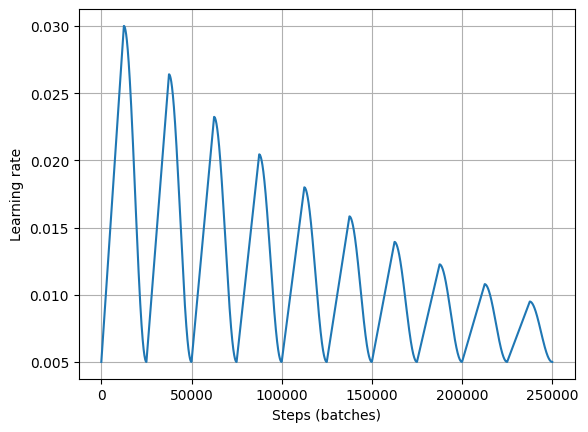

In [20]:
lrs = []
for i in range(n_steps):
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()
plt.plot(list(range(len(lrs))), lrs)
plt.grid()
plt.xlabel('Steps (batches)')
plt.ylabel('Learning rate')

In [21]:
scheduler = CosineAnnealingWarmupRestarts(optimizer, first_cycle_steps=first_cycle_steps, cycle_mult=1.0, 
                                          max_lr=lr, min_lr=min_lr, warmup_steps=warmup_steps, gamma=gamma)

In [22]:
PATH = './cifar_shape_biased_net_{}extra_conv_sgd_lr_{}_gamma_{}_alpha_{}_{}_epochs_randaugs_{}_batch.pth'.format(n_conv_layers,
                                                                                      lr, gamma, alpha, epochs, batch_size)
print('Checkpoints will be saved to:{}'.format(PATH))
def save_checkpoint(model, path):
    print('Saved checkpoint to:{}'.format(path))
    torch.save(model.state_dict(), path)

Checkpoints will be saved to:./cifar_shape_biased_net_4extra_conv_sgd_lr_0.03_gamma_0.88_alpha_1.0_500_epochs_randaugs_100_batch.pth


In [23]:
def test_accuracy():
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = vit(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print('Accuracy of the network on the 10000 test images: %.2f %%' % (accuracy))
    return accuracy

In [24]:
best_test_accuracy = 0
test_accuracy_history = []
lrs_history = []
train_loss_history = []
for epoch in range(epochs):  # loop over the dataset multiple times
    t1 = time.time()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = vit(inputs)
        #log_prb = F.log_softmax(outputs, dim=1)
        #loss = F.cross_entropy(log_prb, labels, reduction='sum')
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        #optimizer.step_and_update_lr()

        # print statistics
        running_loss += loss.item()
        if i % n_batches == (n_batches-1):    # print every 2000 mini-batches
            curr_train_loss = running_loss / (n_batches)
            print('[%d, %5d] loss: %.6f' %
                  (epoch + 1, i + 1, curr_train_loss))
            train_loss_history.append(curr_train_loss)
            lr = optimizer.param_groups[0]["lr"]
            #lr = optimizer._optimizer.param_groups[0]["lr"]
            lrs_history.append(lr)
            print('Learning rate:{}'.format(lr))
            running_loss = 0.0
        
        if i % (n_batches) == (n_batches-1):
            curr_test_accuracy = test_accuracy()
            test_accuracy_history.append(curr_test_accuracy)
            if(curr_test_accuracy > best_test_accuracy):
                best_test_accuracy = curr_test_accuracy
                save_checkpoint(vit, PATH)
        scheduler.step()
        #warmup_scheduler.dampen()
    t2 = time.time()
    print('Time elapsed for epoch:{} is:{}'.format(epoch+1, t2-t1))
print('Finished Training')

[1,   500] loss: 2.252097
Learning rate:0.005998
Accuracy of the network on the 10000 test images: 28.01 %
Saved checkpoint to:./cifar_shape_biased_net_4extra_conv_sgd_lr_0.03_gamma_0.88_alpha_1.0_500_epochs_randaugs_100_batch.pth
Time elapsed for epoch:1 is:57.522899866104126
[2,   500] loss: 2.147516
Learning rate:0.006998
Accuracy of the network on the 10000 test images: 22.92 %
Time elapsed for epoch:2 is:60.04107594490051
[3,   500] loss: 2.014199
Learning rate:0.007998
Accuracy of the network on the 10000 test images: 30.43 %
Saved checkpoint to:./cifar_shape_biased_net_4extra_conv_sgd_lr_0.03_gamma_0.88_alpha_1.0_500_epochs_randaugs_100_batch.pth
Time elapsed for epoch:3 is:66.68709111213684
[4,   500] loss: 1.967902
Learning rate:0.008997999999999999
Accuracy of the network on the 10000 test images: 33.42 %
Saved checkpoint to:./cifar_shape_biased_net_4extra_conv_sgd_lr_0.03_gamma_0.88_alpha_1.0_500_epochs_randaugs_100_batch.pth
Time elapsed for epoch:4 is:82.12912106513977
[5,

In [32]:
vit = ViT(n_layers=n_layers, n_head=n_head, d_k=d_k, d_v=d_v, d_model=d_model, d_inner=d_inner,
         n_classes=n_classes, n_conv_layers=n_conv_layers,alpha=alpha,).to(device)
#vit = torch.nn.DataParallel(vit)

In [33]:
PATH

'./cifar_shape_biased_net_4extra_conv_sgd_lr_0.03_gamma_0.88_alpha_1.0_500_epochs_randaugs_100_batch.pth'

In [34]:
#PATH =  './cifar_net_2extra_conv_sgd_lr_0.05_500_epochs_randaugs_100_batch.pth'
vit.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [35]:
test_accuracies = []
n_trials = 50
t1 = time.time()
for i in range(n_trials):
    test_acc = test_accuracy()
    test_accuracies.append(test_acc)
print('Time taken:{}'.format(time.time() - t1))

Accuracy of the network on the 10000 test images: 90.65 %
Accuracy of the network on the 10000 test images: 90.70 %
Accuracy of the network on the 10000 test images: 90.76 %
Accuracy of the network on the 10000 test images: 90.85 %
Accuracy of the network on the 10000 test images: 90.54 %
Accuracy of the network on the 10000 test images: 90.73 %
Accuracy of the network on the 10000 test images: 90.51 %
Accuracy of the network on the 10000 test images: 90.96 %
Accuracy of the network on the 10000 test images: 90.96 %
Accuracy of the network on the 10000 test images: 90.60 %
Accuracy of the network on the 10000 test images: 90.85 %
Accuracy of the network on the 10000 test images: 90.71 %
Accuracy of the network on the 10000 test images: 90.56 %
Accuracy of the network on the 10000 test images: 90.69 %
Accuracy of the network on the 10000 test images: 90.77 %
Accuracy of the network on the 10000 test images: 90.82 %
Accuracy of the network on the 10000 test images: 90.61 %
Accuracy of th

In [36]:
print('Max accuracy is:{}, min is:{}, and median:{}'.format(np.max(test_accuracies),\
                                                            np.min(test_accuracies),\
                                                            np.median(test_accuracies)))

Max accuracy is:91.16, min is:90.51, and median:90.72


In [37]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = vit(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 92.7 %
Accuracy for class car   is: 94.4 %
Accuracy for class bird  is: 89.4 %
Accuracy for class cat   is: 79.3 %
Accuracy for class deer  is: 90.5 %
Accuracy for class dog   is: 85.2 %
Accuracy for class frog  is: 93.6 %
Accuracy for class horse is: 95.1 %
Accuracy for class ship  is: 93.2 %
Accuracy for class truck is: 93.4 %


# Best accuracy setting so far

**Trial 1**
* './cifar_shape_biased_net_4extra_conv_sgd_lr_0.03_gamma_0.88_alpha_1.0_500_epochs_randaugs_100_batch.pth'

* Max accuracy is:91.16, min is:90.51, and median:90.72
```
epochs = 500
gamma = 0.88
n_steps = epochs*n_batches
print('Total number of batches(steps):{}'.format(n_steps))
criterion = nn.CrossEntropyLoss()
lr = 0.03
optimizer = optim.SGD(vit.parameters(), lr=lr, momentum=0.9)
first_cycle_steps=int(n_batches*50) ## after 50 epochs, a cycle is completed.
print('Steps (batches) for the first cycle to complete:{}'.format(first_cycle_steps))
min_lr = lr / 6
print('Minimum learning rate:{} and maximum learning rate:{} for this scheduler'.format(min_lr, lr))
warmup_steps = int(first_cycle_steps / 2.0)
print('Warmup steps:{}'.format(warmup_steps))
scheduler = CosineAnnealingWarmupRestarts(optimizer, first_cycle_steps=first_cycle_steps, cycle_mult=1.0, 
                                          max_lr=lr, min_lr=min_lr, warmup_steps=warmup_steps, gamma=gamma) 

n_head = 8
n_layers = 6
d_k = 64
d_v = 64
batch = 1
d_inner = 512
d_model = 512
n_classes= 10
alpha=1.0
n_conv_layers = 4
vit = ViT(n_layers=n_layers, n_head=n_head, d_k=d_k, d_v=d_v, d_model=d_model, d_inner=d_inner,
         n_classes=n_classes, n_conv_layers=n_conv_layers,alpha=alpha,).to(device)
```